## Otro paquete: Prince

Veremos algunas aplicaciones elementales del paquete prince. 

Prince es una biblioteca para hacer análisis factorial. Esto incluye una variedad de métodos, incluido el análisis de componentes principales (PCA) y el análisis de correspondencia (CA). El objetivo es proporcionar una implementación eficiente para cada algoritmo junto con una API scikit-learn.


## Consideraciones

Cada estimador proporcionado por prince amplía TransformerMixin de scikit-learn. Esto significa que cada estimador implementa un a función de ajuste y transformación que los hace utilizables en un proceso de transformación. La función de ajuste es en realidad un alias del método row_principal_components que devuelve los componentes principales de la fila. Sin embargo, también puede acceder a los componentes principales de la columna con column_principal_components.

La programación de Prince usa una versión aleatoria de SVD. Esto es mucho más rápido que utilizar el enfoque completo más común. Sin embargo, los resultados pueden tener una pequeña aleatoriedad inherente. Para la mayoría de las aplicaciones, esto no importa y no debería tener que preocuparse por ello. Sin embargo, si desea resultados reproducibles, debe configurar el parámetro random_state.

La versión aleatoria de SVD es un método iterativo. Debido a que cada uno de los algoritmos de Prince usa SVD, todos poseen un parámetro n_iter que controla el número de iteraciones utilizadas para calcular el SVD. Por un lado, cuanto mayor sea n_iter, más precisos serán los resultados. Por otro lado, aumentar n_iter aumenta el tiempo de cálculo. En general, el algoritmo converge muy rápidamente, por lo que se recomienda utilizar un n_iter bajo (que es el comportamiento predeterminado).

Se supone que debe usar cada método según su situación:

* Todas sus variables son numéricas: utilice el análisis de componentes principales (prince.PCA)
* Tienes una tabla de contingencia: usa el análisis de correspondencia (prince.CA)
*  Tiene más de 2 variables y todas son categóricas: use análisis de correspondencia múltiple (prince.MCA)
* Tiene grupos de variables categóricas o numéricas: use análisis de factores múltiples (prince.MFA)
* Tiene variables categóricas y numéricas: utilice el análisis factorial de datos mixtos (prince.FAMD)


## Análisis de componentes principales

Todas las variables numéricas

In [1]:
import pandas as pd
import prince
from sklearn import datasets

X, y = datasets.load_iris(return_X_y=True)
X = pd.DataFrame(data=X, columns=['Sepal length', 'Sepal width', 'Petal length', 'Petal width'])
y = pd.Series(y).map({0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})


In [2]:
X

,Sepal length,Sepal width,Petal length,Petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [3]:
pca = prince.PCA(
    n_components=2,
     n_iter=3,
     rescale_with_mean=True,
     rescale_with_std=True,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
 )
pca = pca.fit(X)


Los parámetros disponibles son:

* n_components: el número de componentes que se calculan. Solo necesita dos si su intención es hacer un gráfico.
* n_iter: el número de iteraciones utilizadas para calcular la SVD
* rescale_with_mean: si restar la media de cada columna
* rescale_with_std: si dividir cada columna por su desviación estándar
* copy: si es False, los cálculos se realizarán en el lugar, lo que puede tener posibles efectos secundarios en los datos de entrada
* engine: qué motor SVD usar (debe ser uno de ['auto', 'fbpca', 'sklearn'])
* random_state: controla la aleatoriedad de los resultados de SVD.

Una vez que se ha ajustado el PCA, se puede utilizar para extraer las coordenadas principales de la fila de la siguiente manera:

In [4]:
pca.transform(X)

,0,1
0,-2.264703,0.480027
1,-2.080961,-0.674134
2,-2.364229,-0.341908
3,-2.299384,-0.597395
4,-2.389842,0.646835
...,...,...
145,1.870503,0.386966
146,1.564580,-0.896687
147,1.521170,0.269069
148,1.372788,1.011254


Cada columna representa un componente principal, mientras que cada fila representa una fila en el conjunto de datos original. Puede mostrar estas proyecciones con el comando plot_row_coordinates:

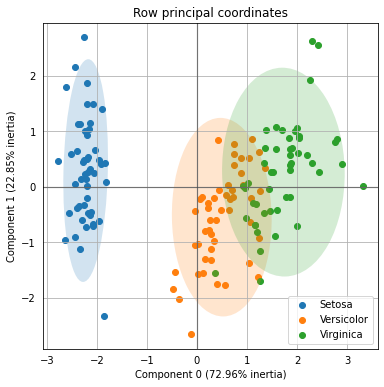

In [5]:
ax = pca.plot_row_coordinates(
   X,
     ax=None,
     figsize=(6, 6),
     x_component=0,
     y_component=1,
     labels=None,
     color_labels=y,
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True
 )

Cada componente principal explica parte del subyacente de la distribución. Puede ver cuánto utilizando el acceso a la explained_inertia_ property:

In [6]:
pca.explained_inertia_ 

[0.7296244541329987, 0.22850761786701776]

La inercia explicada representa el porcentaje de la inercia que aporta cada componente principal. Suma hasta 1 si la propiedad n_components es igual al número de columnas del conjunto de datos original. La inercia explicada se obtiene dividiendo los autovalores obtenidos con la SVD por la inercia total, ambos también accesibles.

In [7]:
pca.eigenvalues_

[437.7746724797993, 137.1045707202107]

In [8]:
pca.total_inertia_  

600.0000000000001

In [9]:
pca.explained_inertia_

[0.7296244541329987, 0.22850761786701776]

También puede obtener las correlaciones entre las variables originales y los componentes principales.

In [10]:
pca.column_correlations(X)

,0,1
Petal length,0.991555,0.023415
Petal width,0.964979,0.064000
Sepal length,0.890169,0.360830
Sepal width,-0.460143,0.882716


También es posible saber cuánto contribuye cada observación a cada componente principal. Esto se puede hacer con el comando row_contributions.

In [11]:
pca.row_contributions(X)

,0,1
0,0.011716,0.001681
1,0.009892,0.003315
2,0.012768,0.000853
3,0.012077,0.002603
4,0.013046,0.003052
...,...,...
145,0.007992,0.001092
146,0.005592,0.005864
147,0.005286,0.000528
148,0.004305,0.007459


También puede transformar las proyecciones de filas a su espacio original utilizando la función inverse_transform.

In [12]:
pca.inverse_transform(pca.transform(X))

,0,1,2,3
0,5.018949,3.514854,1.466013,0.251922
1,4.738463,3.030433,1.603913,0.272074
2,4.720130,3.196830,1.328961,0.167414
3,4.668436,3.086770,1.384170,0.182247
4,5.017093,3.596402,1.345411,0.206706
...,...,...,...,...
145,6.768251,2.993679,5.684797,2.021678
146,6.236857,2.514614,5.317081,1.825121
147,6.581303,2.987266,5.322985,1.865778
148,6.748671,3.302311,5.203441,1.839848


## Análisis de correspondencias

El análisis de correspondencia se utiliza cuando se desea analizar una tabla de contingencia. En otras palabras, buscamos analizar las dependencias entre dos variables categóricas.

In [13]:
import pandas as pd

pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))
X = pd.DataFrame(
   data=[
       [326, 38, 241, 110, 3],
       [688, 116, 584, 188, 4],
       [343, 84, 909, 412, 26],
       [98, 48, 403, 681, 85]],
   columns=pd.Series(['Fair', 'Red', 'Medium', 'Dark', 'Black']),
   index=pd.Series(['Blue', 'Light', 'Medium', 'Dark']))
X


,Fair,Red,Medium,Dark,Black
Blue,326,38,241,110,3
Light,688,116,584,188,4
Medium,343,84,909,412,26
Dark,98,48,403,681,85


In [14]:
ca = prince.CA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42)

In [15]:
X.columns.rename('Hair color', inplace=True)
X.index.rename('Eye color', inplace=True)
ca = ca.fit(X)

In [16]:
ca.row_coordinates(X)

,0,1
Blue,-0.400300,-0.165411
Light,-0.440708,-0.088463
Medium,0.033614,0.245002
Dark,0.702739,-0.133914


In [17]:
ca.column_coordinates(X)

,0,1
Fair,-0.543995,-0.173844
Red,-0.233261,-0.048279
Medium,-0.042024,0.208304
Dark,0.588709,-0.103950
Black,1.094388,-0.286437


Puede trazar ambos conjuntos de coordenadas principales con el método plot_coordinates.

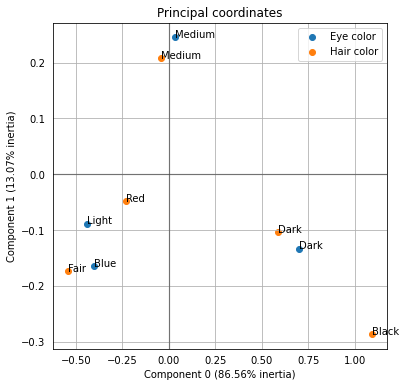

In [18]:
ax = ca.plot_coordinates(
    X=X,
    ax=None,
    figsize=(6, 6),
    x_component=0,
    y_component=1,
    show_row_labels=True,
    show_col_labels=True)

In [19]:
ca.eigenvalues_ 

[0.19924475202819103, 0.03008677410041179]

In [20]:
ca.total_inertia_

0.23019100748666482

In [21]:
ca.explained_inertia_

[0.8655627090025811, 0.13070351630549576]

## Análisis de correspondencias multiples

El análisis de correspondencia múltiple (ACM) es una extensión del análisis de correspondencia (AC). Debería utilizarse cuando tenga más de dos variables categóricas. La idea es simplemente calcular los one-hot-vector de un conjunto de datos y aplicar CA en él. Como ejemplo, usaremos el conjunto de datos de [globos](https://archive.ics.uci.edu/ml/machine-learning-databases/balloons/) tomados del sitio web de conjuntos de datos de UCI.

In [22]:
X = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/balloons/adult+stretch.data')
X.columns = ['Color', 'Size', 'Action', 'Age', 'Inflated']
X

,Color,Size,Action,Age,Inflated
0,YELLOW,SMALL,STRETCH,ADULT,T
1,YELLOW,SMALL,STRETCH,CHILD,F
2,YELLOW,SMALL,DIP,ADULT,F
3,YELLOW,SMALL,DIP,CHILD,F
4,YELLOW,LARGE,STRETCH,ADULT,T
5,YELLOW,LARGE,STRETCH,ADULT,T
6,YELLOW,LARGE,STRETCH,CHILD,F
7,YELLOW,LARGE,DIP,ADULT,F
8,YELLOW,LARGE,DIP,CHILD,F
9,PURPLE,SMALL,STRETCH,ADULT,T


In [23]:
mca = prince.MCA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42)
mca = mca.fit(X)


Usamos nuevamente plot_coordinates

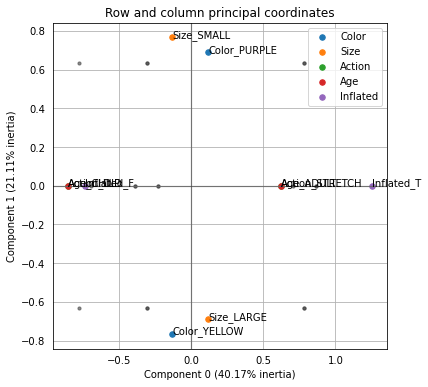

In [26]:
ax = mca.plot_coordinates(
    X=X,
    ax=None,
    figsize=(6, 6),
    show_row_points=True,
    row_points_size=10,
    show_row_labels=False,
    show_column_points=True,
    column_points_size=30,
    show_column_labels=True,
    legend_n_cols=1)

### Análisis de factores múltiple

El análisis de factores múltiples (MFA) está diseñado para usarse cuando tiene grupos de variables. En la práctica, construye un PCA en cada grupo, o un MCA, según los tipos de variables del grupo. Luego, construye un PCA global sobre los resultados de los llamados PCA parciales, o MCA.

El conjunto de datos utilizado en los siguientes ejemplos proviene de este [documento](https://www.utdallas.edu/%7Eherve/Abdi-MFA2007-pretty.pdf). En el conjunto de datos, tres expertos dan su opinión sobre seis vinos diferentes. Cada opinión para cada vino se registra como una variable. Por lo tanto, queremos considerar las opiniones separadas de cada experto y al mismo tiempo tener una visión global de cada vino. MFA es el método perfecto para este tipo de situación.

Primero que nada, copiemos los datos usados en el documento.

In [35]:
X = pd.DataFrame(
    data=[
        [1, 6, 7, 2, 5, 7, 6, 3, 6, 7],
        [5, 3, 2, 4, 4, 4, 2, 4, 4, 3],
        [6, 1, 1, 5, 2, 1, 1, 7, 1, 1],
        [7, 1, 2, 7, 2, 1, 2, 2, 2, 2],
        [2, 5, 4, 3, 5, 6, 5, 2, 6, 6],
        [3, 4, 4, 3, 5, 4, 5, 1, 7, 5]],
    columns=['E1 fruity', 'E1 woody', 'E1 coffee',
             'E2 red fruit', 'E2 roasted', 'E2 vanillin', 'E2 woody',
             'E3 fruity', 'E3 butter', 'E3 woody'],
    index=['Wine {}'.format(i+1) for i in range(6)])
X['Oak type'] = [1, 2, 2, 2, 1, 1]
X

,E1 fruity,E1 woody,E1 coffee,E2 red fruit,E2 roasted,E2 vanillin,E2 woody,E3 fruity,E3 butter,E3 woody,Oak type
Wine 1,1,6,7,2,5,7,6,3,6,7,1
Wine 2,5,3,2,4,4,4,2,4,4,3,2
Wine 3,6,1,1,5,2,1,1,7,1,1,2
Wine 4,7,1,2,7,2,1,2,2,2,2,2
Wine 5,2,5,4,3,5,6,5,2,6,6,1
Wine 6,3,4,4,3,5,4,5,1,7,5,1


Los grupos se pasan como un diccionario a la clase MFA.

In [36]:
groups = {
   'Expert #{}'.format(no+1): [c for c in X.columns if c.startswith('E{}'.format(no+1))]
   for no in range(3)
}
print(groups)

{'Expert #1': ['E1 fruity', 'E1 woody', 'E1 coffee'], 'Expert #2': ['E2 red fruit', 'E2 roasted', 'E2 vanillin', 'E2 woody'], 'Expert #3': ['E3 fruity', 'E3 butter', 'E3 woody']}


Ajustamos un MFA

In [37]:
mfa = prince.MFA(
    groups=groups,
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42)
mfa = mfa.fit(X)


El MFA hereda de la clase PCA, lo que implica que tiene acceso a todos sus métodos y propiedades. El método row_coordinates devolverá las coordenadas globales de cada vino.

In [38]:
mfa.row_coordinates(X)

,0,1
Wine 1,-2.172155,-0.508596
Wine 2,0.557017,-0.197408
Wine 3,2.317663,-0.830259
Wine 4,1.832557,0.905046
Wine 5,-1.403787,0.054977
Wine 6,-1.131296,0.576241


Al igual que para el PCA, puede trazar las coordenadas de la fila con el comando plot_row_coordinates.

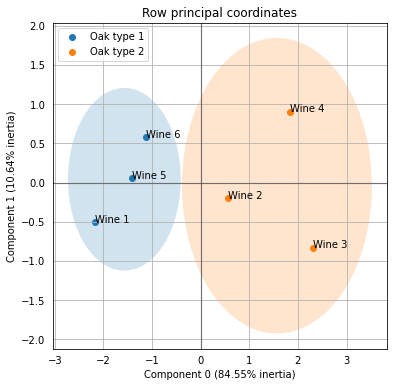

In [39]:
ax = mfa.plot_row_coordinates(
    X,
    ax=None,
    figsize=(6, 6),
    x_component=0,
    y_component=1,
    labels=X.index,
    color_labels=['Oak type {}'.format(t) for t in X['Oak type']],
    ellipse_outline=False,
    ellipse_fill=True,
    show_points=True)

También puede obtener las coordenadas de las filas dentro de cada grupo. El método parcial_row_coordinates devuelve un pandas.DataFrame donde el conjunto de columnas es un pandas.MultiIndex. El primer nivel de indexación corresponde a cada grupo especificado, mientras que el nivel anidado indica las coordenadas dentro de cada grupo.

In [41]:
mfa.partial_row_coordinates(X)

Expert #1           Expert #2           Expert #3          
               0         1         0         1         0         1
Wine 1 -2.764432 -1.104812 -2.213928 -0.863519 -1.538106  0.442545
Wine 2  0.773034  0.298919  0.284247 -0.132135  0.613771 -0.759009
Wine 3  1.991398  0.805893  2.111508  0.499718  2.850084 -3.796390
Wine 4  1.981456  0.927187  2.393009  1.227146  1.123206  0.560803
Wine 5 -1.292834 -0.620661 -1.492114 -0.488088 -1.426414  1.273679
Wine 6 -0.688623 -0.306527 -1.082723 -0.243122 -1.622541  2.278372

plot_partial_row_coordinates permite visualizar la opinion de cada experto

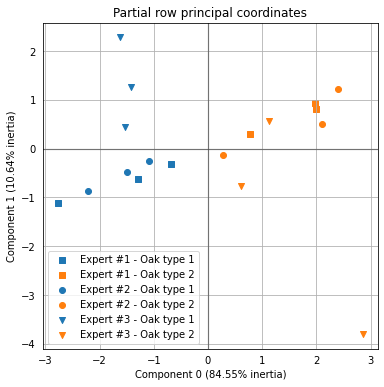

In [42]:
ax = mfa.plot_partial_row_coordinates(
    X,
    ax=None,
    figsize=(6, 6),
    x_component=0,
    y_component=1,
    color_labels=['Oak type {}'.format(t) for t in X['Oak type']])

In [43]:
mfa.eigenvalues_

[2.834800672096379, 0.3568590491209077]

In [44]:
mfa.total_inertia_

3.3530042099448787

In [45]:
mfa.explained_inertia_

[0.8454509730970429, 0.10642964540947422]

In [48]:
for name, fa in sorted(mfa.partial_factor_analysis_.items()): 
    print('{} inertia: {}'.format(name, fa.explained_inertia_))

Expert #1 inertia: [0.9541983544156208, 0.039945443174869213]
Expert #2 inertia: [0.9127709835868826, 0.04853976454159999]
Expert #3 inertia: [0.8268296179640892, 0.1470651449979216]
